# Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import strftime
from datetime import datetime


# Customer Segmentation

This is a technique of scoring and classify customers based on 3 important metrics. i)Recency,ii)Frequency and iii)Monitary.
The customers are given a score range of 1-5 with 1 the lowest score and 5 the highest score.

**Kenya**

In [2]:
# Import relevant dataset(Kenyan Orders)
df=pd.read_csv("Kenya Orders.csv")
print(df.shape)
df.head(3)

(12242, 47)


,Order ID,Order Status,Category Name,SKU,Customization Group,Customization Option,Quantity,Unit Price,Cost Price,Total Cost Price,...,Commission Amount,Commission Payout Status,Order Preparation Time,Debt Amount,Redeemed Loyalty Points,Consumed Loyalty Points,Cancellation Reason,Flat Discount,Checkout Template Name,Checkout Template Value
0,11265015,ORDERED,Cooking Fat & Oil,KKCO0487,NaN,NaN,1,4400,4250,4250,...,NaN,NaN,0,-,50,-,NaN,0,-,-
1,11264651,ORDERED,Cleaning & Hygiene,KKPT280100,NaN,NaN,1,180,130,130,...,NaN,NaN,0,-,-,-,NaN,0,-,-
2,11264651,ORDERED,Flour & Sugar,KKFS0702,NaN,NaN,6,263,247,1482,...,NaN,NaN,0,-,-,-,NaN,0,-,-


Recency

In [3]:
df['Order Time']= pd.to_datetime(df['Order Time'], dayfirst=True)#convert to pandas datetime format
df_recency = df.groupby(by='Customer ID',
                        as_index=False)['Order Time'].max()
df_recency.columns = ['Customer_ID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.sample(5)

,Customer_ID,LastPurchaseDate,Recency
47,3761185,2022-02-15 21:06:32+00:00,1
548,5188263,2022-02-17 12:59:40+00:00,0
57,3815751,2022-01-05 19:43:34+00:00,42
325,4467362,2022-02-13 19:49:54+00:00,3
150,4027232,2022-02-14 22:01:11+00:00,2


Frequency

In [4]:
frequency_df = df.drop_duplicates().groupby(
    by=['Customer ID'], as_index=False)['Order Time'].count()
frequency_df.columns = ['Customer_ID', 'Frequency']
frequency_df.head()

,Customer_ID,Frequency
0,3365019,4
1,3365770,44
2,3377953,5
3,3378262,26
4,3385533,28


Calculating Monetary Value

In [5]:
df['Total'] = df['Total Price']
monetary_df = df.groupby(by='Customer ID', as_index=False)['Total'].sum()
monetary_df.columns = ['Customer_ID', 'Monetary']
monetary_df.head()

,Customer_ID,Monetary
0,3365019,10836
1,3365770,65255
2,3377953,43489
3,3378262,66411
4,3385533,25631


Merging all the columns into 1 dataframe

In [6]:
rf_df = df_recency.merge(frequency_df, on='Customer_ID')
rfm_df = rf_df.merge(monetary_df, on='Customer_ID').drop(
    columns='LastPurchaseDate')
rfm_df.sample(5)

,Customer_ID,Recency,Frequency,Monetary
230,4129395,0,6,11590
471,4880051,27,7,8765
518,5135713,11,4,3940
403,4588320,14,21,19996
291,4334864,6,14,99493


Ranking CUstomers based on their Frequency,Recency and Monitory 

In [7]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.sample(5)

,Customer_ID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
520,5144456,10,10,8127,43.274854,57.818182,57.818182
499,4948686,27,4,2450,21.832359,33.363636,33.363636
146,4026233,32,2,4336,17.056530,12.454545,12.454545
401,4575951,41,2,2216,6.042885,12.454545,12.454545
36,3741824,12,19,97098,39.961014,72.000000,72.000000


Calculating the RFM score 

In [8]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
    rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['Customer_ID', 'RFM_Score']].sample(4)

,Customer_ID,RFM_Score
518,5135713,1.73
208,4097460,4.20
290,4333460,0.56
345,4495249,2.28


Rating customers based on thr RFM Score

In [9]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
                                      4.5, "Top Customers",
                                      (np.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    rfm_df['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfm_df['RFM_Score'] > 1.6,
                            'Low Value Customers', 'Lost Customers'))))))
rfm_df[['Customer_ID', 'RFM_Score', 'Customer_segment']].sample(10)

,Customer_ID,RFM_Score,Customer_segment
372,4543676,2.60,Low Value Customers
44,3758306,0.58,Lost Customers
282,4308344,1.72,Low Value Customers
73,3874460,4.95,Top Customers
425,4669823,4.89,Top Customers
81,3896139,1.25,Lost Customers
317,4455405,3.63,Medium Value Customer
206,4095299,2.13,Low Value Customers
62,3826113,3.38,Medium Value Customer
436,4744979,4.86,Top Customers


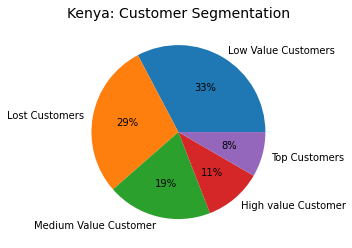

In [10]:
# Pie plot of the optained results
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.title('Kenya: Customer Segmentation',fontsize=14)
plt.show()

**Nigeria**

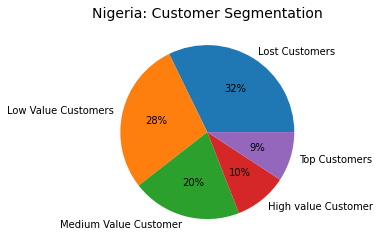

In [11]:
df1=pd.read_csv("Nigeria Orders.csv")
df1['Order Time']= pd.to_datetime(df1['Order Time'], dayfirst=True)#convert to pandas datetime format
# Recency
df_recency = df1.groupby(by='Customer ID',
                        as_index=False)['Order Time'].max()
df_recency.columns = ['Customer_ID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
# Frequency
frequency_df = df1.drop_duplicates().groupby(
    by=['Customer ID'], as_index=False)['Order Time'].count()
frequency_df.columns = ['Customer_ID', 'Frequency']
# Monitary
df1['Total'] = df1['Total Price']
monetary_df = df1.groupby(by='Customer ID', as_index=False)['Total'].sum()
monetary_df.columns = ['Customer_ID', 'Monetary']
#Merging the files
rf_df = df_recency.merge(frequency_df, on='Customer_ID')
rfm_df = rf_df.merge(monetary_df, on='Customer_ID').drop(
    columns='LastPurchaseDate')

rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
#RFM-Score
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
    rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['Customer_ID', 'RFM_Score']]

#Segmentation
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
                                      4.5, "Top Customers",
                                      (np.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    rfm_df['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfm_df['RFM_Score'] > 1.6,
                            'Low Value Customers', 'Lost Customers'))))))
rfm_df[['Customer_ID', 'RFM_Score', 'Customer_segment']]
# Pie plot of the optained results
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.title('Nigeria: Customer Segmentation',fontsize=14)
plt.show()

# Cohort Analysis

**Kenya**

In [12]:
# Loading relevant datasets.
customers_kenya=pd.read_csv("Kenya Customers.csv")
data=df.merge(customers_kenya[['Customer ID','Created At']],on='Customer ID',how='left')
print(data.shape,df.shape)
data.head(2)

(12242, 49) (12242, 48)


,Order ID,Order Status,Category Name,SKU,Customization Group,Customization Option,Quantity,Unit Price,Cost Price,Total Cost Price,...,Order Preparation Time,Debt Amount,Redeemed Loyalty Points,Consumed Loyalty Points,Cancellation Reason,Flat Discount,Checkout Template Name,Checkout Template Value,Total,Created At
0,11265015,ORDERED,Cooking Fat & Oil,KKCO0487,NaN,NaN,1,4400,4250,4250,...,0,-,50,-,NaN,0,-,-,4400,2021-06-11T15:42:57.000Z
1,11264651,ORDERED,Cleaning & Hygiene,KKPT280100,NaN,NaN,1,180,130,130,...,0,-,-,-,NaN,0,-,-,180,2021-11-09T15:40:46.000Z


In [14]:
#Convert columns to datetime 
data['Delivery Time']= pd.to_datetime(data['Delivery Time'], dayfirst=True)#convert to pandas datetime format
data['Created At']= pd.to_datetime(data['Created At'], dayfirst=True)
data['month_year'] = pd.to_datetime(data['Created At']).dt.to_period('M')#split date to month and year
#calculate Age by month e.g Age_Month 10 means the user was on his/her 10th month since sign-up
data['Age_Month'] = (data['Delivery Time'] - data['Created At']).dt.days + 1
data['Age_Month'] = data['Age_Month']/30
data.Age_Month = data.Age_Month.round()
data['Age_Month']=data['Age_Month']+1
data.sample(5)

,Order ID,Order Status,Category Name,SKU,Customization Group,Customization Option,Quantity,Unit Price,Cost Price,Total Cost Price,...,Redeemed Loyalty Points,Consumed Loyalty Points,Cancellation Reason,Flat Discount,Checkout Template Name,Checkout Template Value,Total,Created At,month_year,Age_Month
308,11246072,ORDERED,Cooking Fat & Oil,KKCFO1420,NaN,NaN,2,2158,2125,4250,...,77,-,NaN,0,-,-,4316,2021-07-22 08:11:07+00:00,2021-07,8.0
1088,11196522,COMPLETED,Salt & Seasoning,KKSS0002,NaN,NaN,1,65,58,58,...,-,35,NaN,0,-,-,65,2021-07-03 08:57:17+00:00,2021-07,9.0
3014,11071783,COMPLETED,Flour & Sugar,KKFS0401,NaN,NaN,1,25,21.11,21.11,...,25,36,NaN,0,-,-,25,2021-07-29 11:06:12+00:00,2021-07,7.0
3116,11070650,COMPLETED,Flour & Sugar,KKFS0104,NaN,NaN,1,1720,1680,1680,...,15,74,NaN,0,-,-,1720,2021-06-21 17:00:54+00:00,2021-06,9.0
333,11244503,COMPLETED,Cooking Fat & Oil,KKCFO1420,NaN,NaN,1,2158,2125,2125,...,30,56,NaN,0,-,-,2158,2021-06-07 07:04:57+00:00,2021-06,10.0


Pivot table

In [15]:
group = data.groupby(['month_year', 'Age_Month'])
cohort_data = group['Customer ID'].size()
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='month_year', columns='Age_Month', values='Customer ID')
cohort_counts

Age_Month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
month_year,,,,,,,,,,,
2021-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,55.0
2021-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,398.0,207.0,NaN
2021-06,NaN,NaN,NaN,NaN,NaN,NaN,13.0,387.0,458.0,5.0,NaN
2021-07,NaN,NaN,NaN,NaN,NaN,63.0,866.0,733.0,36.0,NaN,NaN
2021-08,NaN,NaN,NaN,NaN,28.0,828.0,1381.0,17.0,NaN,NaN,NaN
2021-09,NaN,NaN,NaN,21.0,492.0,587.0,9.0,NaN,NaN,NaN,NaN
2021-10,NaN,NaN,90.0,421.0,342.0,1.0,NaN,NaN,NaN,NaN,NaN
2021-11,NaN,32.0,1143.0,660.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-12,54.0,887.0,869.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


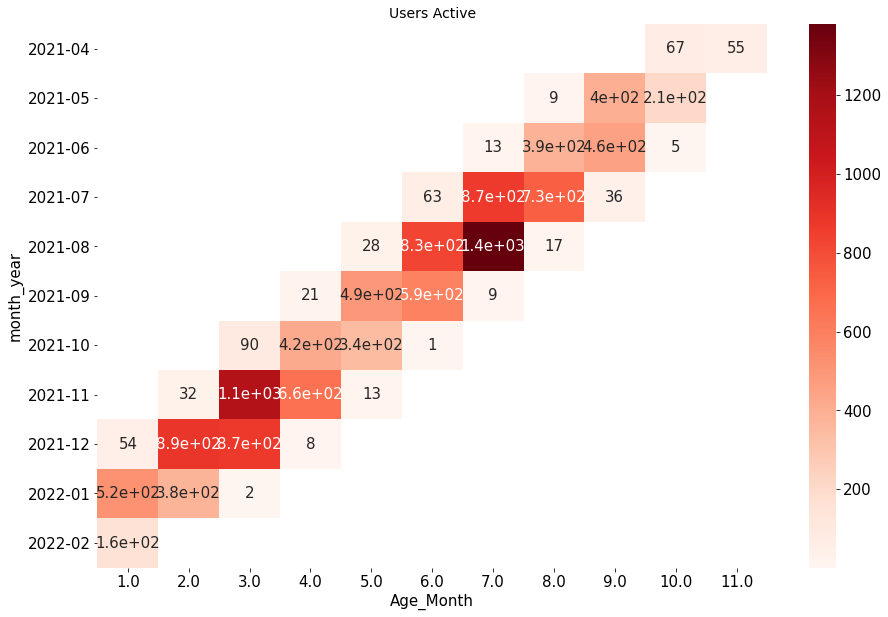

In [16]:
# User Count heatmap
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})
plt.title('Users Active',fontsize=14)
ax = sns.heatmap(data=cohort_counts, annot=True,cmap='Reds')
plt.show()

**Nigeria**

In [17]:
# Loading relevant datasets.
customers_Nigeria=pd.read_csv("Nigeria Customers.csv")
data=df1.merge(customers_Nigeria[['Customer ID','Created At']],on='Customer ID',how='left')
print(data.shape,df.shape)
data['Delivery Time']= pd.to_datetime(data['Delivery Time'], dayfirst=True)#convert to pandas datetime format
data['Created At']= pd.to_datetime(data['Created At'], dayfirst=True)
data['month_year'] = pd.to_datetime(data['Created At']).dt.to_period('M')#split date to month and year
#calculate Age by month e.g Age_Month 10 means the user was on his/her 10th month since sign-up
data['Age_Month'] = (data['Delivery Time'] - data['Created At']).dt.days + 1
data['Age_Month'] = data['Age_Month']/30
data.Age_Month = data.Age_Month.round()
data['Age_Month']=data['Age_Month']+1

#pivot table
group = data.groupby(['month_year', 'Age_Month'])
cohort_data = group['Customer ID'].size()
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='month_year', columns='Age_Month', values='Customer ID')
cohort_counts

(1429, 48) (12242, 48)


Age_Month,1.0,2.0,3.0,4.0,5.0,6.0,7.0
month_year,,,,,,,
2021-08,NaN,NaN,NaN,NaN,11.0,139.0,161.0
2021-09,NaN,NaN,NaN,NaN,78.0,84.0,1.0
2021-10,NaN,NaN,14.0,231.0,198.0,2.0,NaN
2021-11,NaN,12.0,168.0,109.0,3.0,NaN,NaN
2021-12,NaN,33.0,87.0,2.0,NaN,NaN,NaN
2022-01,67.0,14.0,NaN,NaN,NaN,NaN,NaN
2022-02,15.0,NaN,NaN,NaN,NaN,NaN,NaN


The data quality issue is also observed on the Nigerian data
We can however see a retention rate of 21%(14/67) for the group that signed up on January 2022.
A dataase audit should be carried and come up with an accurate data flow architecture which gives room for data analysis and scalability.

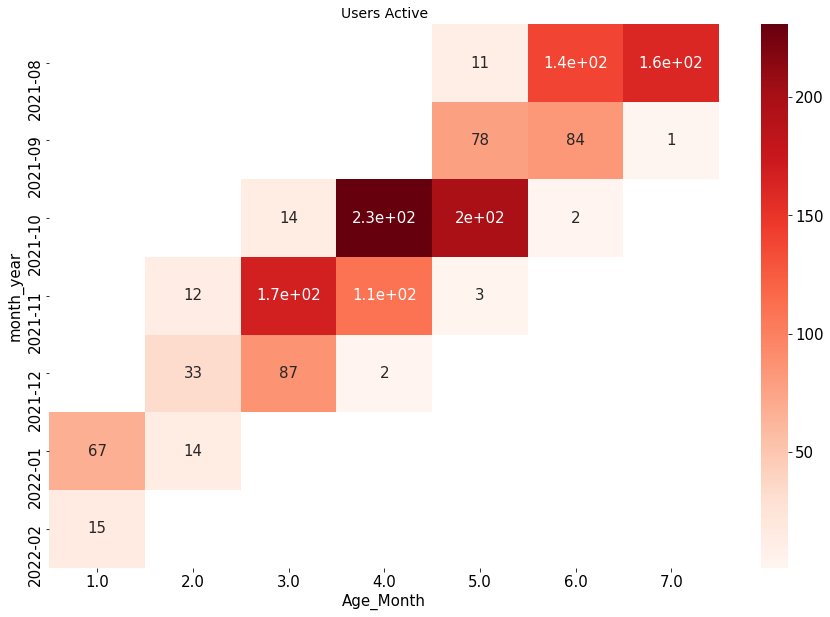

In [18]:
# User Count heatmap
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})
plt.title('Users Active',fontsize=14)
ax = sns.heatmap(data=cohort_counts, annot=True,cmap='Reds')
plt.show()

# Product Recommendations